In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
import pandas as pd
import re
import matplotlib
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':22}
matplotlib.rc('font', **font)

In [2]:
def degree(g, nodes=None, as_list=True):
    deg = dict(g.degree())
    if nodes: deg = dict(g.degree(nodes))
    
    if as_list: return list(deg.values())
    return deg

def degree_plot(g, nodes=None, filename=None, title=''):
    deg = degree(g, nodes=nodes)
    bins = 100
    if len(nodes) < 100:
        bins = len(nodes)
    hist = np.histogram(deg, bins=bins)
    freqs, edges = hist[0], hist[1]
    n = freqs.size
    means = [(edges[i] + edges[i+1]) / 2 for i in range(n)]
    
    # SCATTER PLOT
    plt.figure(figsize=[15,10])
    plt.plot(means, freqs, ".", markersize=20)
    plt.xlabel("k")
    plt.ylabel("frequency")
    plt.title("Degree distribution for %s" % title)
    if filename: plt.savefig('plots/%s.svg' % filename, format='svg', bbox_inches="tight")
    plt.show()
    
    # LOG LOG PLOT
    plt.figure(figsize=[15,10])
    plt.loglog(means, freqs, ".", markersize=20)
    plt.xlabel("log(k)")
    plt.ylabel("log(frequency)")
    plt.title("Log-log degree distribution for %s" % title)
    if filename: plt.savefig('plots/log_%s.svg' % filename, format='svg', bbox_inches="tight")
    plt.show()

### Read datasets

In [235]:
# Constant Strings
USER = 'user'
ELITE_USER = 'elite_user'
BIZ = 'biz'

# Read in data
biz = pd.read_csv('toronto/toronto_biz.csv')
user = pd.read_csv('toronto/toronto_users.csv')
reviews = pd.read_csv('toronto/toronto_reviews.csv')
elite_user = user[~user.elite.str.contains('None')]

print('#Reviews:', len(reviews))
print('#Users:', len(set(reviews.user_id)))
print('#Elite users:', len(elite_user))
print('#Businesses:', len(set(reviews.business_id)))

#Reviews: 379875
#Users: 84624
#Elite users: 7499
#Businesses: 9678


### Create the review network

In [4]:
# A node class for storing data.
class Node:
    def __init__(self, Data, Type):
        self.Data = Data
        self.Type = Type
    
    def to_string(self):
        return "Node (%s), Data: " % (self.Type, self.Data)
    
    def __hash__(self):
        return hash(self.Data)
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.Data == other.Data
               )

In [16]:
review_network = nx.Graph()
elite_ids = set(elite_user.user_id)
for r in reviews.itertuples():
    a = Node(r.user_id, ELITE_USER if r.user_id in elite_ids else USER)
    b = Node(r.business_id, BIZ)
    review_network.add_edge(a, b, weight=r.stars)

#### Degree distributions

In [64]:
review_biz_nodes = [n for n in list(review_network.nodes()) if n.Type == BIZ]
review_user_nodes = [n for n in list(review_network.nodes()) if n.Type == USER]
review_elite_nodes = [n for n in list(review_network.nodes()) if n.Type == ELITE_USER]

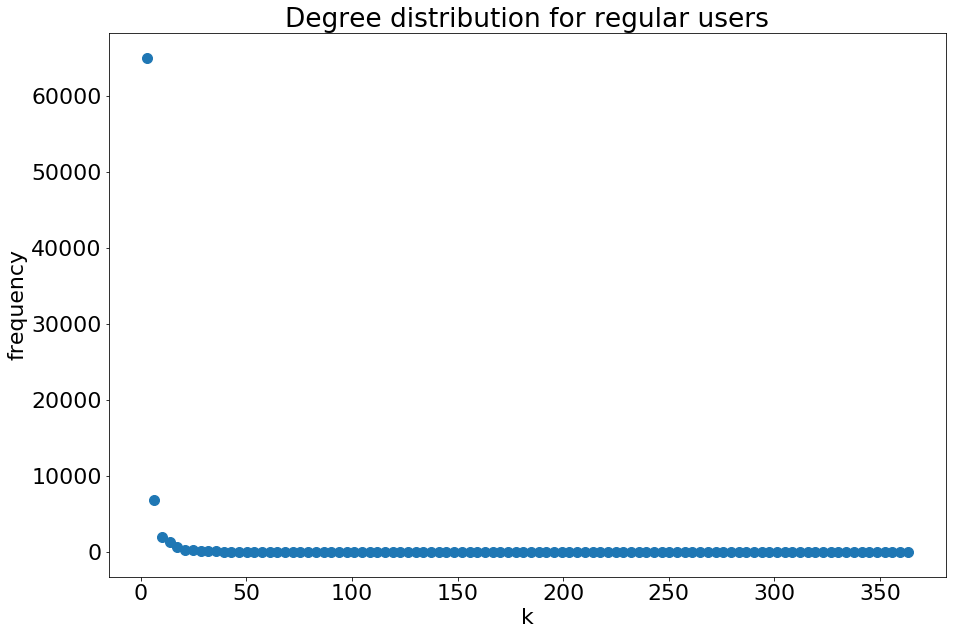

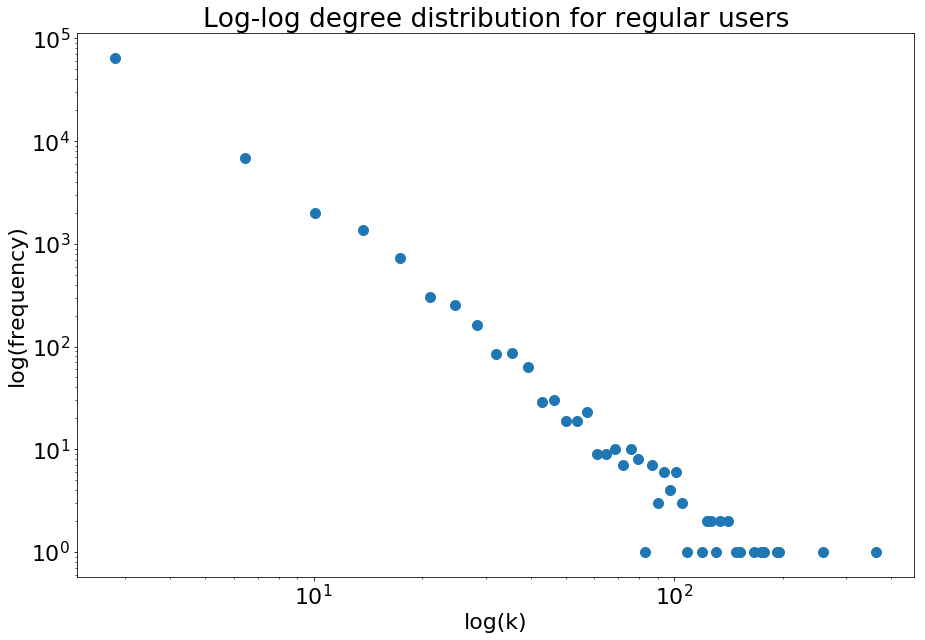

In [231]:
degree_plot(review_network, review_user_nodes, title="regular users", filename='reviews_degree_regular')

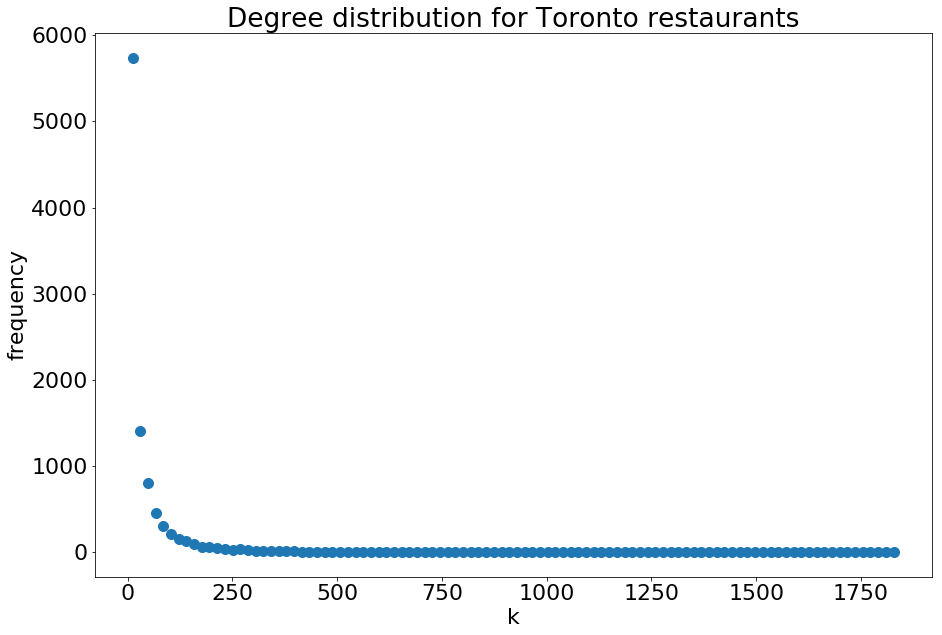

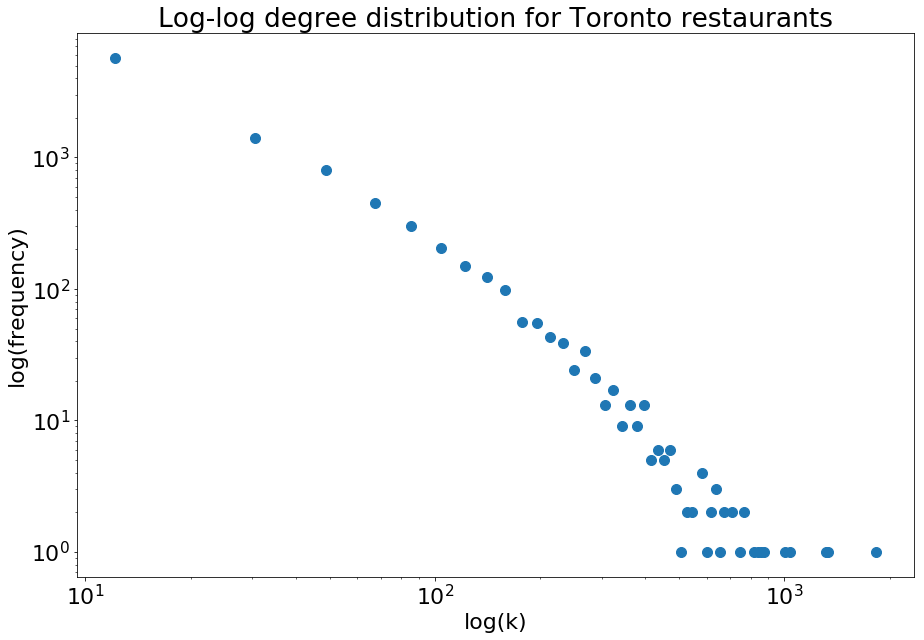

In [226]:
degree_plot(review_network, review_biz_nodes, title="Toronto restaurants", filename='reviews_degree_biz')

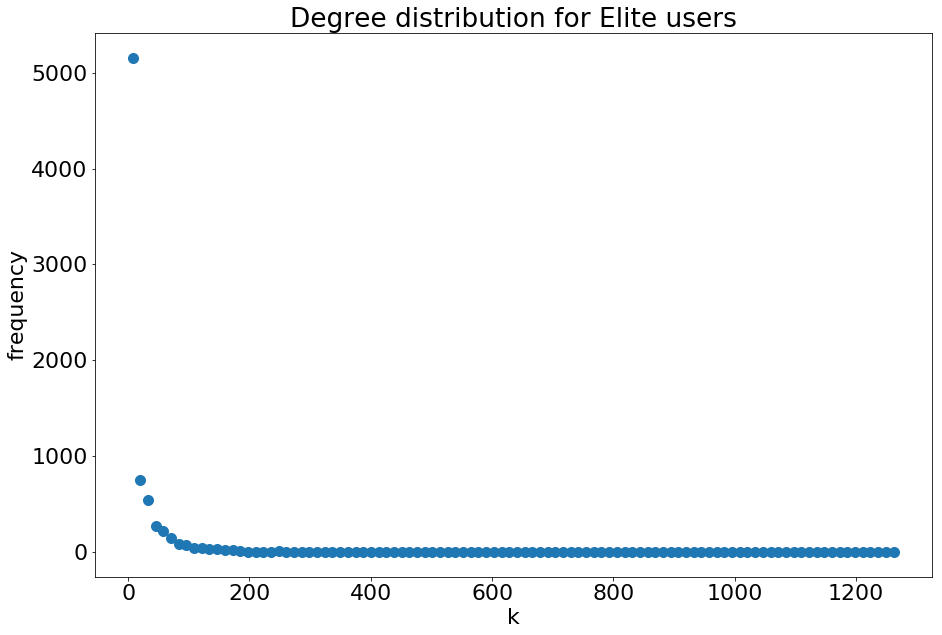

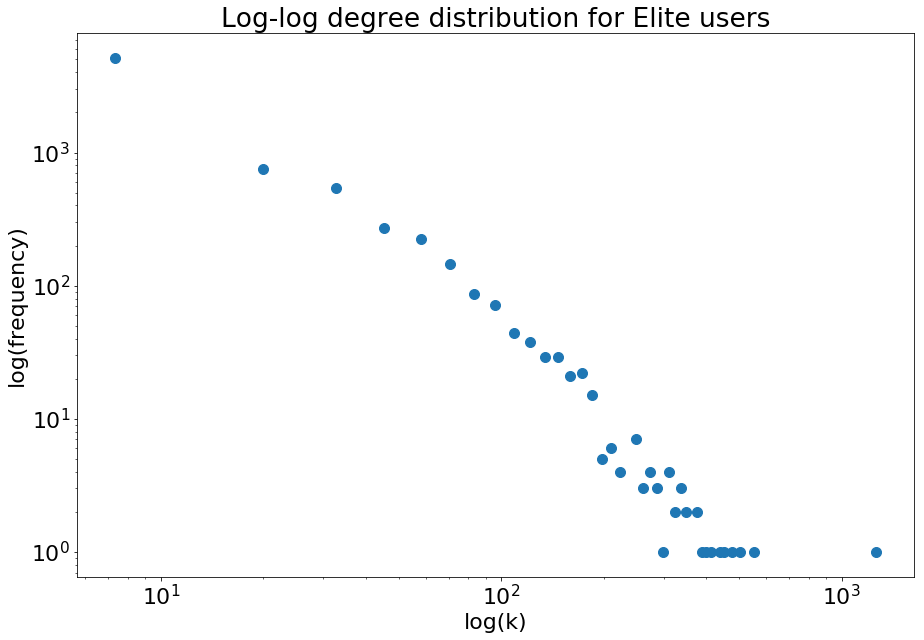

In [232]:
degree_plot(review_network, review_elite_nodes, title="Elite users", filename='reviews_degree_elite')

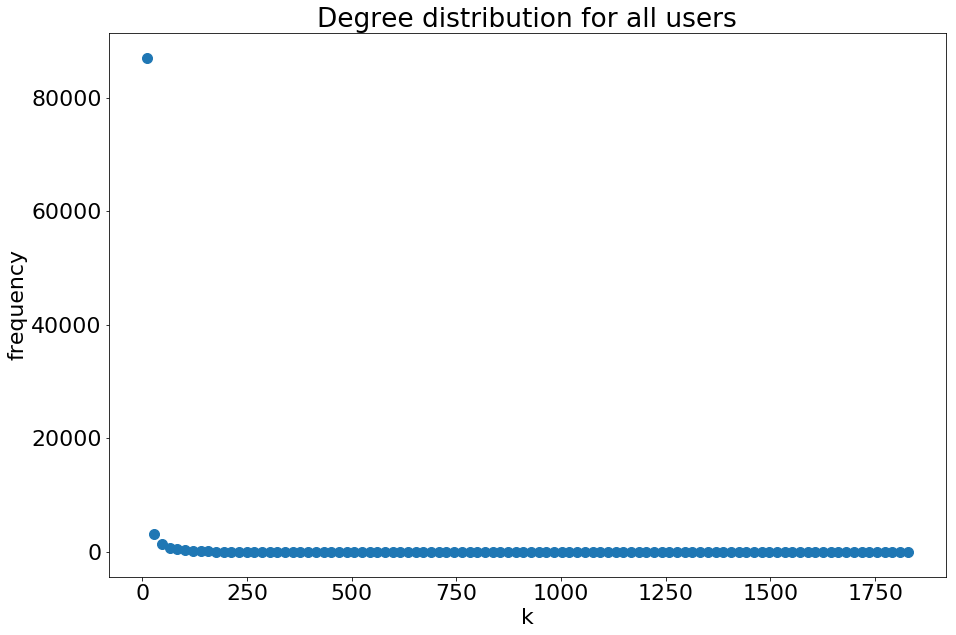

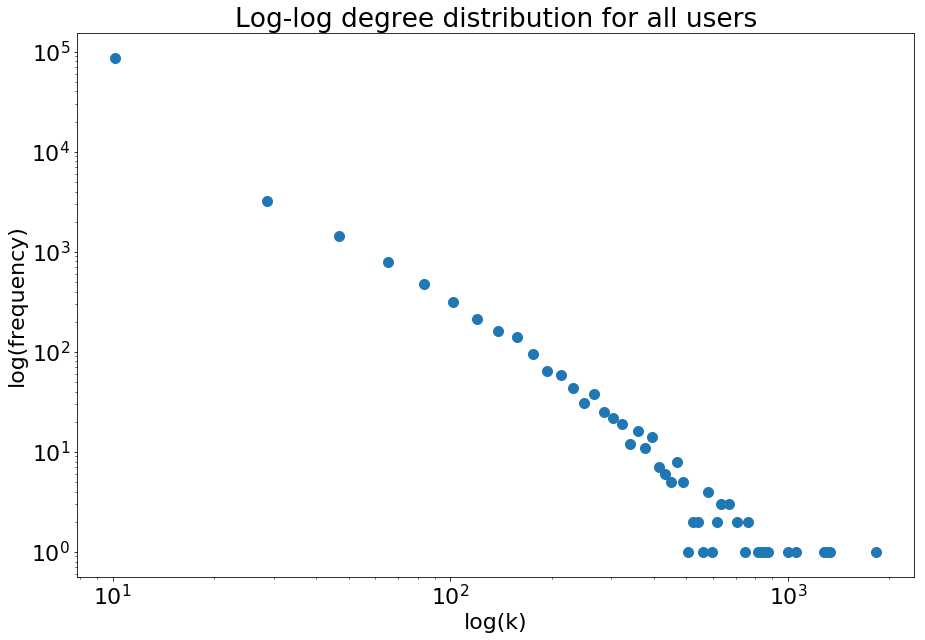

In [233]:
degree_plot(review_network, review_network.nodes(), title="all users", filename='reviews_degree_all')

In [18]:
print('Nodes:', len(review_network.nodes()))
print('Edges:', len(review_network.edges()))

Nodes: 94291
Edges: 379875


In [77]:
L = max(nx.connected_component_subgraphs(review_network), key=len)
print("Nodes in largest subcomponent:", len(L.nodes()))
print("Edges in largest subcomponent:", len(L.edges()))

Nodes in largest subcomponent: 94246
Edges in largest subcomponent: 379840


In [78]:
cluster_coeff_avg = nx.average_clustering(review_network)
print('Average clustering coeff. :', cluster_coeff_avg)

Average clustering coeff. : 2.843489088264669e-06


In [ ]:
nx

### Centrality: Elite vs Non-Elite

**Intro:** Eigenvector centrality for a user node indicates to which degree they have reviewed restaurants with many reviews.

In [20]:
deg = nx.degree(review_network)
ev = nx.eigenvector_centrality_numpy(review_network)

In [21]:
ev_elite_user = [ev[n] for n in ev if n.Type == ELITE_USER]
ev_user = [ev[n] for n in ev if n.Type == USER]
elite_avg_ev = np.mean(ev_elite_user)
user_avg_ev = np.mean(ev_user)
all_user_ev = np.mean(ev_elite_user + ev_user)

In [22]:
deg_elite_user = [deg[n] for n in deg if n.Type == ELITE_USER]
deg_user = [deg[n] for n in deg if n.Type == USER]
elite_avg_deg = np.mean(deg_elite_user)
user_avg_deg = np.mean(deg_user)
all_user_deg = np.mean(deg_elite_user + deg_user)

In [23]:
print('Normal user mean EV centrality', user_avg_ev)
print('Elite user mean EV centrality', elite_avg_ev)
print('All users mean EV centrality', all_user_ev)
ratio = elite_avg_ev / user_avg_ev
print('Ratio (Elite : Normal): %.2f' % ratio)

Normal user mean EV centrality 0.0005151721690592373
Elite user mean EV centrality 0.0034574370628518815
All users mean EV centrality 0.0007759271614785319
Ratio (Elite : Normal): 6.71


In [24]:
print('Normal user mean Deg centrality', user_avg_deg)
print('Elite user mean Deg centrality', elite_avg_deg)
print('All users mean Deg centrality', all_user_deg)
ratio = elite_avg_deg / user_avg_deg
print('Ratio Deg (Elite : Normal): %.2f' % ratio)

Normal user mean Deg centrality 3.0597274271561394
Elite user mean Deg centrality 19.19215895452727
All users mean Deg centrality 4.489446440389524
Ratio Deg (Elite : Normal): 6.27


**Conclusion:** Elite users on average review 6.3 times as many restaurants, and review the most reviewed restaurants 6.7 times as frequently. This means that there is a small tendendency for elite users to review the more popular restaurants moreso, than other restaurants.

In [61]:
user['ev'] = 0

In [72]:
ev_user = {n.Data: ev[n] for n in ev if (n.Type == ELITE_USER) or (n.Type == USER)}

In [81]:
i = 1
p = int(len(ev_user) / 100)
for k in ev_user:
    if  i % p == 0: print('%i percent done' % (i/p))
    eigenvalue = ev_user[k]
    user.loc[user.user_id == k, 'ev'] = eigenvalue
    i += 1

1 percent done
2 percent done
3 percent done
4 percent done
5 percent done
6 percent done
7 percent done
8 percent done
9 percent done
10 percent done
11 percent done
12 percent done
13 percent done
14 percent done
15 percent done
16 percent done
17 percent done
18 percent done
19 percent done
20 percent done
21 percent done
22 percent done
23 percent done
24 percent done
25 percent done
26 percent done
27 percent done
28 percent done
29 percent done
30 percent done
31 percent done
32 percent done
33 percent done
34 percent done
35 percent done
36 percent done
37 percent done
38 percent done
39 percent done
40 percent done
41 percent done
42 percent done
43 percent done
44 percent done
45 percent done
46 percent done
47 percent done
48 percent done
49 percent done
50 percent done
51 percent done
52 percent done
53 percent done
54 percent done
55 percent done
56 percent done
57 percent done
58 percent done
59 percent done
60 percent done
61 percent done
62 percent done
63 percent done
6

In [82]:
user.to_csv('toronto/toronto_users.csv')

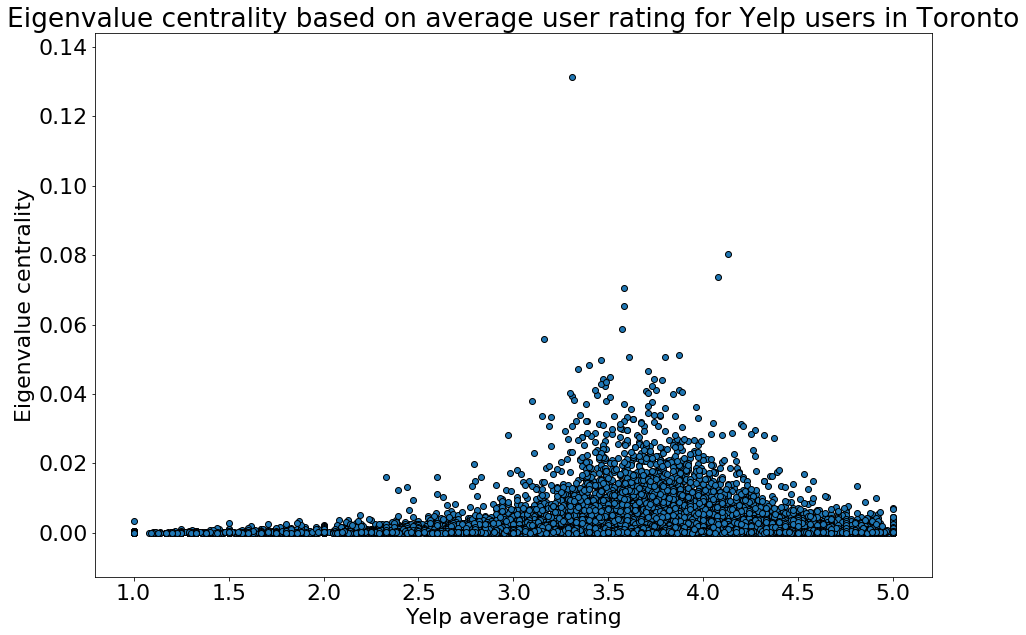

In [238]:
plt.figure(figsize=[15,10])
plt.scatter(user.average_stars, user.ev, edgecolors='black')
plt.xlabel('Yelp average rating')
plt.ylabel('Eigenvalue centrality')
plt.title('Eigenvalue centrality based on average user rating for Yelp users in Toronto')
plt.savefig('plots/user_rating_ev.svg', format='svg', bbox_inches="tight")
plt.show()

/Users/tnni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


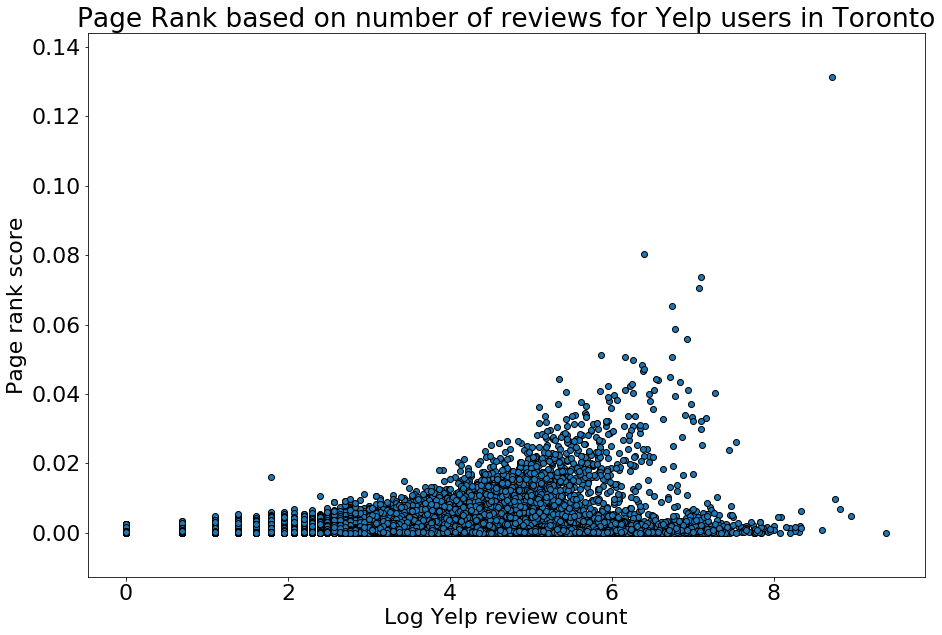

In [121]:
plt.figure(figsize=[15,10])
plt.scatter(np.log(user.review_count), user.ev, edgecolors='black')
plt.xlabel('Log Yelp review count')
plt.ylabel('Page rank score')
plt.title('Page Rank based on number of reviews for Yelp users in Toronto')
plt.savefig('plots/log_user_count_ev.svg', format='svg', bbox_inches="tight")
plt.show()

In [44]:
ev_biz = {n.Data: ev[n] for n in ev if n.Type == BIZ}
deg_biz = {n.Data: deg[n] for n in deg if n.Type == BIZ}

In [126]:
biz.ev = biz['ev']

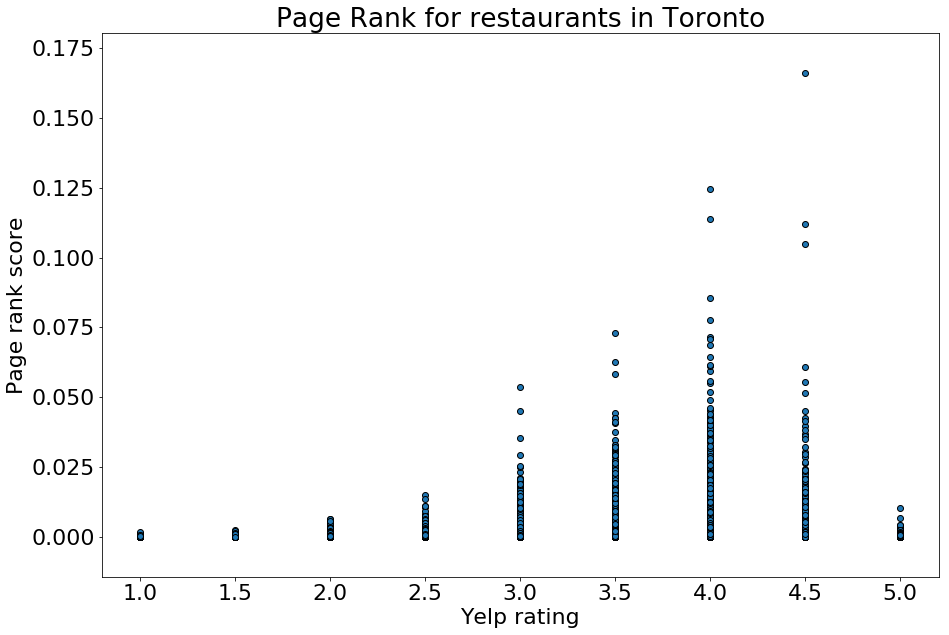

In [127]:
plt.figure(figsize=[15,10])
plt.scatter(biz.stars, biz.ev, edgecolors='black')
plt.xlabel('Yelp rating')
plt.ylabel('Page rank score')
plt.title('Page Rank for restaurants in Toronto')
plt.savefig('plots/biz_rating_ev.svg', format='svg', bbox_inches="tight")
plt.show()

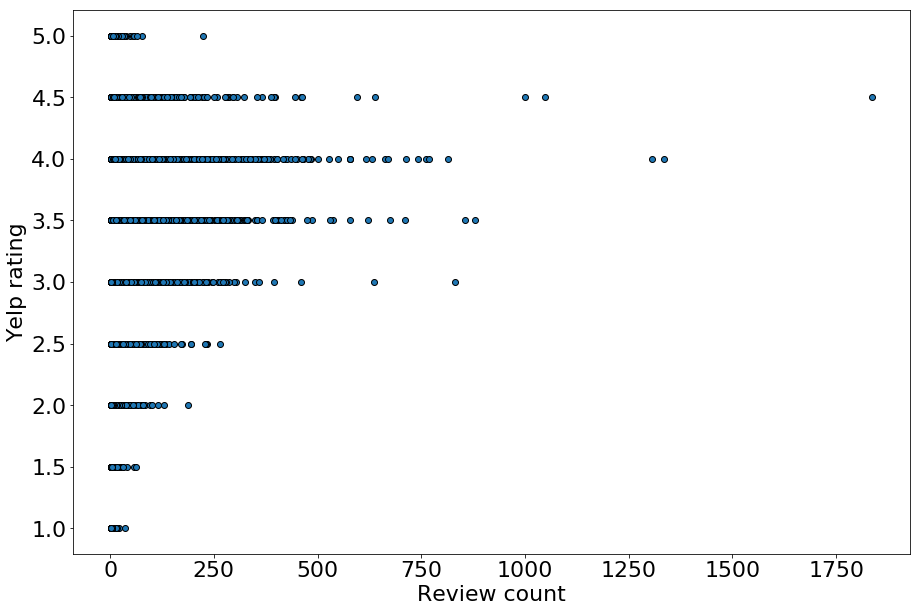

In [57]:
plt.figure(figsize=[15,10])
plt.scatter(biz.review_count, biz.stars, edgecolors='black')
plt.ylabel('Yelp rating')
plt.xlabel('Review count')
plt.show()

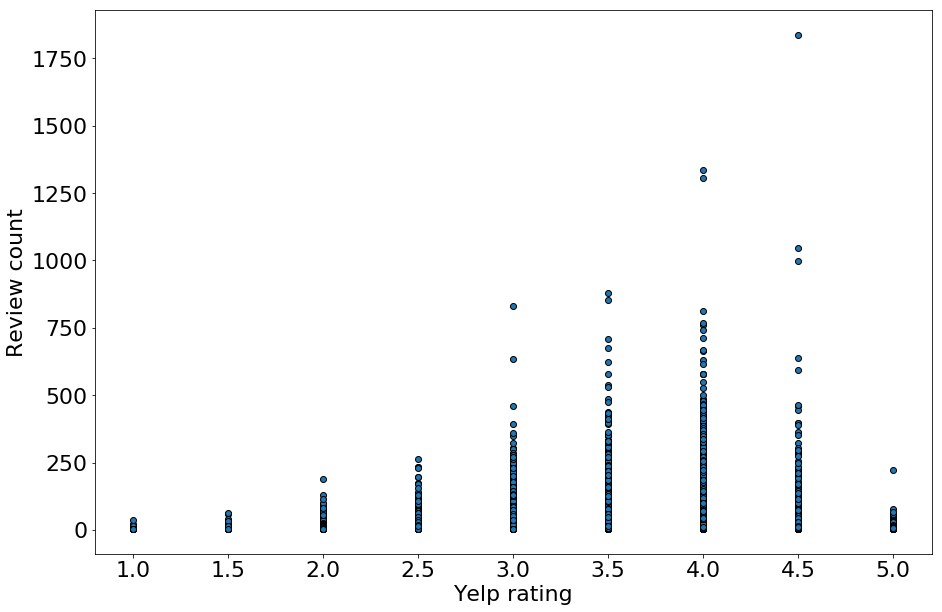

In [56]:
plt.figure(figsize=[15,10])
plt.scatter(biz.stars, biz.review_count, edgecolors='black')
plt.xlabel('Yelp rating')
plt.ylabel('Review count')
plt.show()

**Conclusion**: There seems to be a trend in Toronto where, the more the reviews a restaurant has, the higher the rating the restaurant has. This however is normally distributed around a score of 4, and it seems to regress when a business scores higher than 4.0 on average.

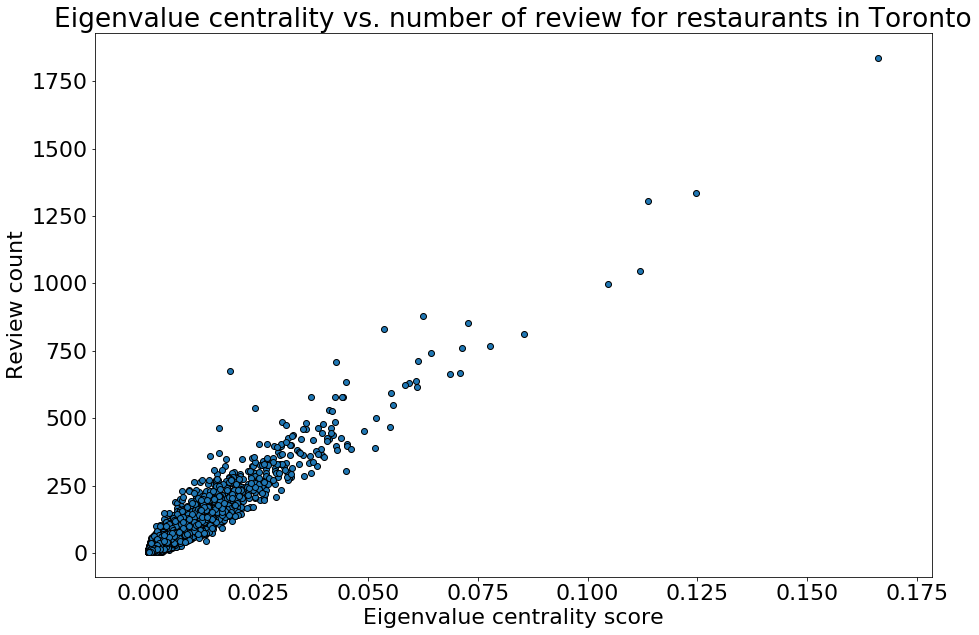

In [237]:
plt.figure(figsize=[15,10])
plt.scatter(biz.ev, biz.review_count, edgecolors='black')
plt.xlabel('Eigenvalue centrality score')
plt.ylabel('Review count')
plt.title('Eigenvalue centrality vs. number of review for restaurants in Toronto')
plt.savefig('plots/biz_ev_count.svg', format='svg', bbox_inches="tight")
plt.show()

**Conclusion**: Eigenvector centrality score seems to be directly linked to degree, which is unsurprising since the more reviews a restaurant has, the higher the chances are that the reviewers are elite, and thus giving the restaurant a higher eigenvalue score.

In [213]:
print("Elite reviews:", elite_stars.shape)
print("Reg reviews:", regular_stars.shape)
print("All reviews:", all_stars.shape)

Elite reviews: (143922,)
Reg reviews: (235953,)
All reviews: (379875,)


In [216]:
print("Elite reviews make up %.2f percent of all reviews:" % (100 * len(elite_stars) / len(all_stars)))

Elite reviews make up 37.89 percent of all reviews:


In [212]:
regular_stars.shape

(235953,)

In [191]:
elite_stars = np.array(reviews[reviews.user_id.isin(elite_user.user_id)].stars)
regular_stars = np.array(reviews[~reviews.user_id.isin(elite_user.user_id)].stars)
all_stars = np.array(reviews.stars)

reg = np.histogram(regular_stars, bins=[1,2,3,4,5,6])[0]
reg = reg / sum(reg)

elit = np.histogram(elite_stars, bins=[1,2,3,4,5,6])[0]
elit = elit / sum(elit)

all_ = np.histogram(all_stars, bins=[1,2,3,4,5,6])[0]
all_ = all_ / sum(all_)

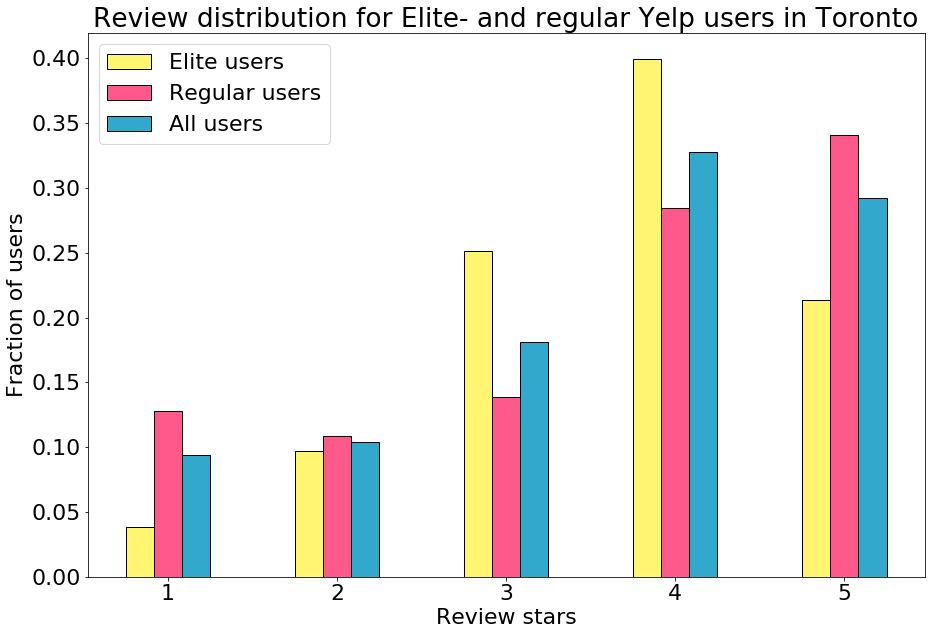

In [204]:
plt.figure(figsize=[15,10])
x = np.array([1,2,3,4,5])
dx = 1/12
plt.bar(x - 2*dx, height=elit, width=2*dx, color='#FFF571', edgecolor='black')
plt.bar(x, height=reg, width=2*dx, color='#FF588A', edgecolor='black')
plt.bar(x + 2*dx, height=all_, width=2*dx, color='#32A9CC', edgecolor='black')
plt.xlabel('Review stars')
plt.ylabel('Fraction of users')
plt.legend(['Elite users', 'Regular users', 'All users'])
plt.title('Review distribution for Elite- and regular Yelp users in Toronto')
plt.savefig('plots/review_dist.svg', format='svg', bbox_inches="tight")
plt.show()

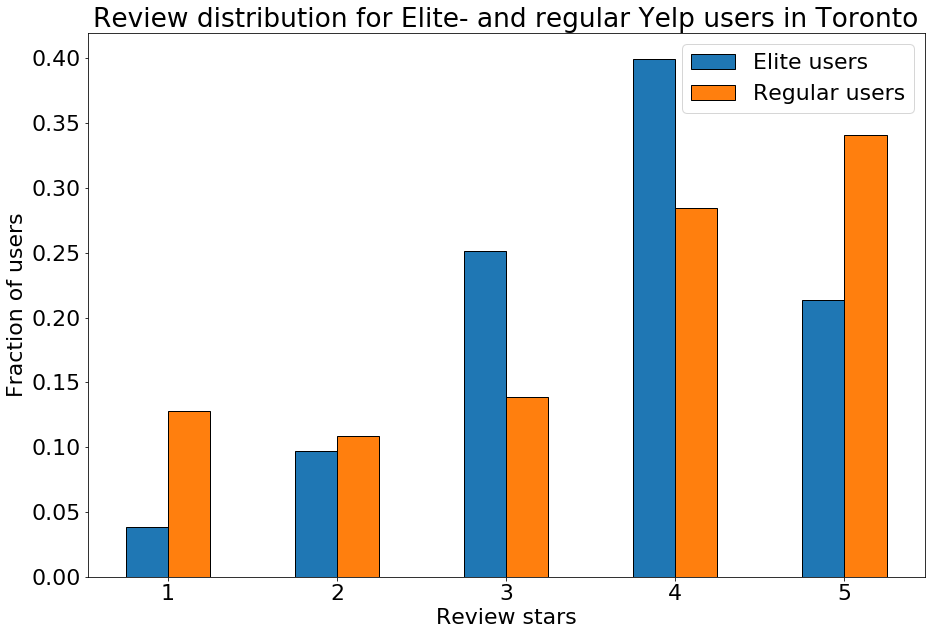

In [208]:
plt.figure(figsize=[15,10])
x = np.array([1,2,3,4,5])
dx = 0.125
plt.bar(x - dx, height=elit, width=2*dx, edgecolor='black')
plt.bar(x + dx, height=reg, width=2*dx, edgecolor='black')
plt.xlabel('Review stars')
plt.ylabel('Fraction of users')
plt.legend(['Elite users', 'Regular users'])
plt.title('Review distribution for Elite- and regular Yelp users in Toronto')
plt.savefig('plots/review_dist.svg', format='svg', bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=[15,10])
x = np.array([1,2,3,4,5])
dx = 0.125
plt.bar(x - dx, height=elit, width=2*dx, edgecolor='black')
plt.bar(x + dx, height=reg, width=2*dx, edgecolor='black')
plt.xlabel('Review stars')
plt.ylabel('Fraction of users')
plt.legend(['Elite users', 'Regular users'])
plt.title('Review distribution for Elite- and regular Yelp users in Toronto')
plt.savefig('plots/review_dist.svg', format='svg', bbox_inches="tight")
plt.show()

**Conclusion:** Elite users are more moderate and peak at 4 stars, where regular users are more critical and over-enthustiastic, i.e. giving 1 star reviews, and 5 star reviews.

In [146]:
# Only regular user reviews
reg_biz_graph = nx.subgraph(review_network, review_user_nodes + review_biz_nodes)
reg_weights_dict = reg_biz_graph.degree(review_biz_nodes, weight='weight')
reg_degrees_dict = reg_biz_graph.degree(review_biz_nodes)
reg_biz_ratings_dict = {
    node.Data: reg_weights_dict[node] / reg_degrees_dict[node] 
    for node in review_biz_nodes
    if reg_degrees_dict[node] > 0
}

In [147]:
# Only elite reviews
elite_biz_graph = nx.subgraph(review_network, review_elite_nodes + review_biz_nodes)
elite_weights_dict = elite_biz_graph.degree(review_biz_nodes, weight='weight')
elite_degrees_dict = elite_biz_graph.degree(review_biz_nodes)
elite_biz_ratings_dict = {
    node.Data: elite_weights_dict[node] / elite_degrees_dict[node]
    for node in review_biz_nodes
    if elite_degrees_dict[node] > 0
}

In [153]:
# All user reviews
all_weights_dict = review_network.degree(review_biz_nodes, weight='weight')
all_degrees_dict = review_network.degree(review_biz_nodes)
all_biz_ratings_dict = {
    node.Data: all_weights_dict[node] / all_degrees_dict[node] 
    for node in review_biz_nodes
    if all_degrees_dict[node] > 0
}

In [ ]:
biz_ids = [b.Data for b in review_biz_nodes]

In [205]:
# Comparison REGULAR AND ELITE
deltas_elite_reg = {
    biz_id: elite_biz_ratings_dict[biz_id] - reg_biz_ratings_dict[biz_id]
    for biz_id in biz_ids
    if biz_id in reg_biz_ratings_dict.keys()
    and biz_id in elite_biz_ratings_dict.keys()
}

In [206]:
# Comparison ALL AND ELITE
deltas_elite_all = {
    biz_id: elite_biz_ratings_dict[biz_id] - all_biz_ratings_dict[biz_id]
    for biz_id in biz_ids
    if biz_id in all_biz_ratings_dict.keys()
    and biz_id in elite_biz_ratings_dict.keys()
}

In [207]:
# Comparison ALL AND REG
deltas_reg_all = {
    biz_id: reg_biz_ratings_dict[biz_id] - all_biz_ratings_dict[biz_id]
    for biz_id in biz_ids
    if biz_id in all_biz_ratings_dict.keys()
    and biz_id in reg_biz_ratings_dict.keys()
}

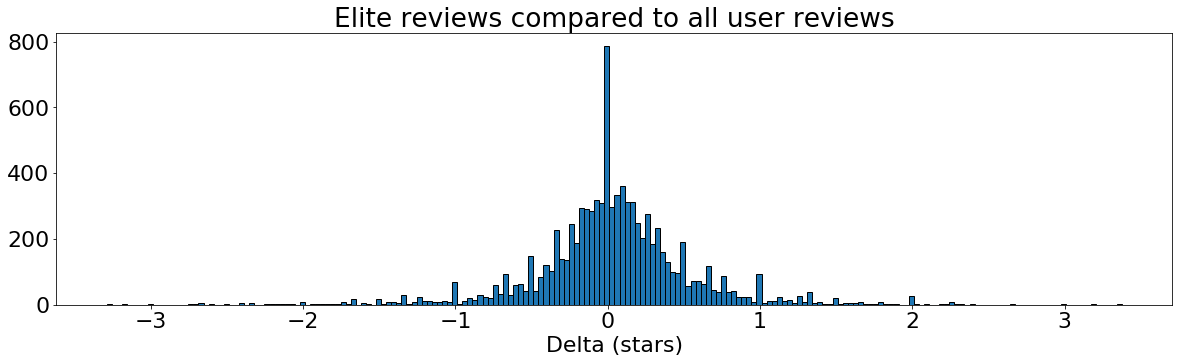

In [208]:
plt.figure(figsize=[20,5])
plt.hist(np.array(list(deltas_elite_all.values())), bins=200, edgecolor='black')
plt.xlabel('Delta (stars)')
plt.title('Elite reviews compared to all user reviews')
plt.savefig('plots/delta_elite_all.svg', format='svg', bbox_inches="tight")
plt.show()

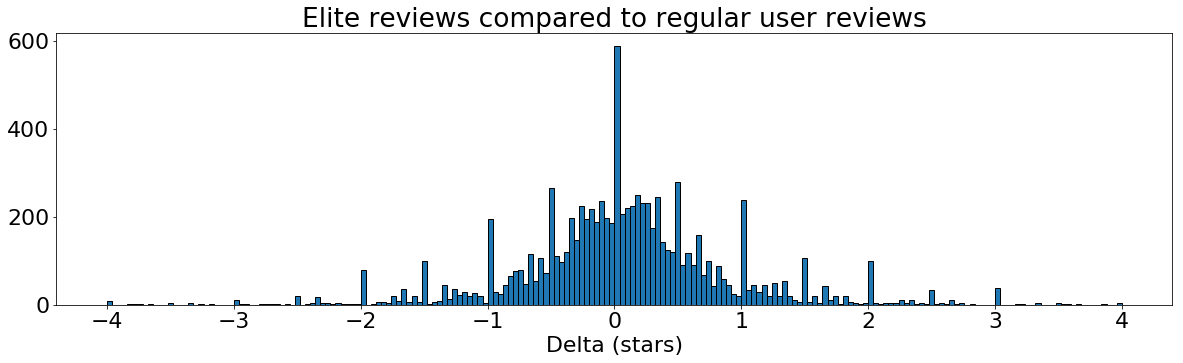

In [209]:
plt.figure(figsize=[20,5])
plt.hist(np.array(list(deltas_elite_reg.values())), bins=200, edgecolor='black')
plt.xlabel('Delta (stars)')
plt.title('Elite reviews compared to regular user reviews')
plt.savefig('plots/delta_elite_reg.svg', format='svg', bbox_inches="tight")
plt.show()

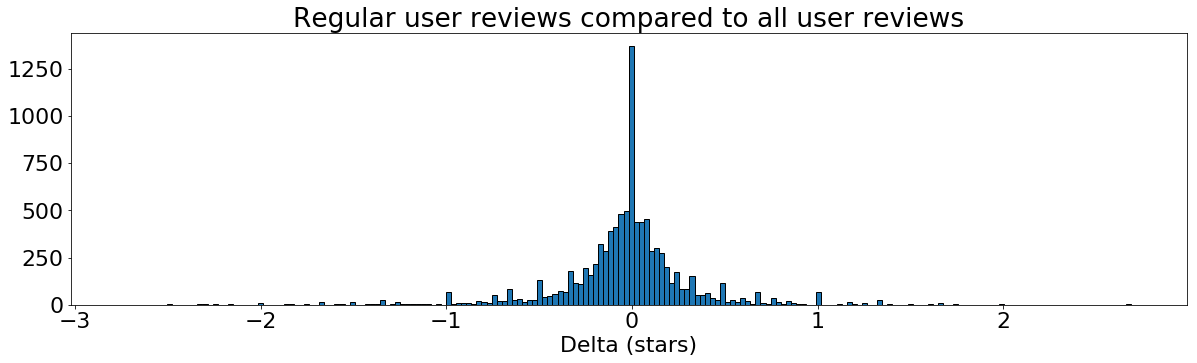

In [210]:
plt.figure(figsize=[20,5])
plt.hist(np.array(list(deltas_reg_all.values())), bins=200, edgecolor='black')
plt.xlabel('Delta (stars)')
plt.title('Regular user reviews compared to all user reviews')
plt.savefig('plots/delta_all_reg.svg', format='svg', bbox_inches="tight")
plt.show()

In [63]:
biz_sorted_by_rating = biz.sort_values('stars',ascending=False)
list(biz_sorted_by_rating.name)[:10]

['Street Feast Grill',
 'Patisserie Saint Honore',
 'Banh Mi Boys',
 "The Captain's Boil",
 'Gaia Natural Foods',
 'Sweet Flour Bake Shop',
 'Umami Poke',
 'T-Sushi',
 'Fast Fresh Foods',
 'Oak Island']

In [50]:
elite_reviews = reviews[reviews.user_id.isin(elite_user.user_id)]
elite_biz = biz[biz.business_id.isin(elite_reviews.business_id)]
elite_biz_sorted_by_rating = elite_biz.sort_values('stars',ascending=False)
list(elite_biz_sorted_by_rating.name)[:10]

['Starbank Convenience',
 "Sorauren Farmers' Market",
 'FruiteaO',
 'Urban Bistro',
 'De La Mer',
 'The Gastro Pub',
 'Little Green Planet',
 'Park Hyatt Toronto Kosher Annona Restaurant',
 'Village Juicery',
 'Teappuccino']